# Immune disease classifier

## Research Question:
Is it possible to build a model for multi-class classification of immune system malignancies and diseases? By observing single-cell transcriptomic states, can we predict the disease from a set of 12:

    B-cell acute lymphoblastic leukemia
    B-cell non-Hodgkin lymphoma
    Crohn's disease
    Cholangitis
    Common variable immunodeficiency
    Follicular lymphoma
    Localized scleroderma
    Multiple sclerosis
    Plasma cell myeloma
    Premalignant hematological system disease
    Systemic lupus erythematosus
    Type 1 diabetes mellitus
## Data Source:
CellxGene Census – a collection of single-cell transcriptomics data from multiple patients.
  
    https://chanzuckerberg.github.io/cellxgene-census/

## Techniques Used in Analysis:
Each cell (entry) contains 50,000 features, and differential gene expression was performed to down-select only the most important features.
Cell types were balanced using synthetic cells generated through Poisson noise applied to real cells.
Multiple models were trained for multi-class prediction and tested on unseen patients to ensure high precision and recall.

## Expected Results:
A classifier capable of distinguishing between 12 immune system diseases, reliably diagnosing each patient with precision and high recall.

## Bussiness objectives:
This research aims to explore a novel data modality—single-cell transcriptomics—for diagnostics, which has not yet been widely applied in this domain. The development of a universal model capable of distinguishing between immune diseases using uniform molecular input, without relying on phenotypic data, could significantly enhance decision-making in medicine and supplement the $15B immune disease diagnostics market.

Currently, diagnostic tools predominantly rely on phenotypic markers, which can make it difficult to differentiate between diseases with overlapping clinical presentations. However, these diseases are distinguishable at the molecular level. This research seeks to harness molecular data to create a universal model for diagnosing immune diseases, even in the absence of additional phenotypic information.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay,confusion_matrix, roc_curve, roc_auc_score, multilabel_confusion_matrix, classification_report
from sklearn.metrics import auc as skl_auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.exceptions import ConvergenceWarning
set_config("figure")

# Suppress only ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Suppress all warnings globally
warnings.filterwarnings("ignore")


## Read the data

Data is stored in a special AnnData object that allows to hold multiple matrices of data as well as variables and obseravtion lists together, it is specifically desinged for handingling big data problems in single cell omics.

In [2]:
#Data is lodaed in a special object called AnnData
adata = sc.read_h5ad('data/disease_dataset_balanced.h5ad')

## Feature understanding

In [3]:
# Description of data
adata

AnnData object with n_obs × n_vars = 1647995 × 4328
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'is_real_cell'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'geneformer', 'scgpt', 'scvi'

In [4]:
# I am using scanpy's method to normalize data to number of counts per gene per 10,000 reads (read is a unit of transcription depth), since each cell can have different depth we are normalizing each gene depth for each cell by the total depth of the cell divided by 10,000
sc.pp.normalize_total(adata, target_sum=10000)
# To further regularize data I have log1p transformed the dataset
sc.pp.log1p(adata)

In [5]:
# Count how many cells are real and how many are synthetic
adata.obs['is_real_cell'].value_counts()

is_real_cell
fake         1134392
real          442540
augmented      71063
Name: count, dtype: int64

#### Note:
    There are 1,134,392 fake cells and 442,540 real cells and 71,063 cells that are augmented
    Fake cells are cells added as decoys - they have incorrect disease labels, and exist to confuse model from learning specific cell types
    Real cells are actual real cells
    Augmented cells are real cells with added poisson noise used to help cell type populations that are below 30 cells.

#### I have trained on datasets including and excluding fake cells - fake cells balance dataset so that model can't learn which cell type is disease associated which is beneficial from learning about specific disease gene networks but it makes the learning process much more difficult. 

In [6]:
#Reset index
adata.obs.reset_index(drop=True, inplace=True)

In [7]:
# Count how many real and augmented cells are per disease
adata.obs[(adata.obs['is_real_cell']=='real') | (adata.obs['is_real_cell']=='augmented')]['disease'].value_counts()

disease
Crohn disease                                131618
B-cell acute lymphoblastic leukemia           76144
primary sclerosing cholangitis                60945
systemic lupus erythematosus                  52157
common variable immunodeficiency              42499
follicular lymphoma                           36960
primary biliary cholangitis                   29163
B-cell non-Hodgkin lymphoma                   25964
premalignant hematological system disease     25661
type 1 diabetes mellitus                      12049
plasma cell myeloma                           10437
multiple sclerosis                             9020
localized scleroderma                           986
Name: count, dtype: int64

In [8]:
# Count how many real, augmented and fake cells are there per disease
adata.obs['disease'].value_counts()

disease
Crohn disease                                187321
B-cell acute lymphoblastic leukemia          156423
systemic lupus erythematosus                 145282
primary sclerosing cholangitis               140940
follicular lymphoma                          126936
premalignant hematological system disease    121699
common variable immunodeficiency             120362
B-cell non-Hodgkin lymphoma                  114093
type 1 diabetes mellitus                     109637
primary biliary cholangitis                  109158
plasma cell myeloma                          107908
multiple sclerosis                           104125
localized scleroderma                        104111
Name: count, dtype: int64

## Features engineering

#### Note: I have merge both cholangitis-related diseases into single label
    Primary sclerosing cholangitis and Primary biliary cholangitis are very simillar diseases and I have made decision to not differentiate between them.

In [9]:
# Add category for Cholongitis
adata.obs['disease'] = adata.obs['disease'].cat.add_categories('cholangitis')
# Reassign primary sclerosing cholangitis to Cholongitis
adata.obs.loc[adata.obs['disease'] == 'primary sclerosing cholangitis', 'disease'] = 'cholangitis'
# Reassign primary biliary cholangitis to Cholongitis
adata.obs.loc[adata.obs['disease'] == 'primary biliary cholangitis', 'disease'] = 'cholangitis'
# Remove primary biliary cholangitis and primary sclerosing cholangitis from categories
adata.obs['disease'] = adata.obs['disease'].cat.remove_categories(['primary sclerosing cholangitis', 'primary biliary cholangitis'])

In [10]:
#Reset index
adata.obs.reset_index(drop=True, inplace=True)

In [11]:
# Count how many real and augmented cells are per disease
adata.obs[(adata.obs['is_real_cell']=='real') | (adata.obs['is_real_cell']=='augmented')]['disease'].value_counts()

disease
Crohn disease                                131618
cholangitis                                   90108
B-cell acute lymphoblastic leukemia           76144
systemic lupus erythematosus                  52157
common variable immunodeficiency              42499
follicular lymphoma                           36960
B-cell non-Hodgkin lymphoma                   25964
premalignant hematological system disease     25661
type 1 diabetes mellitus                      12049
plasma cell myeloma                           10437
multiple sclerosis                             9020
localized scleroderma                           986
Name: count, dtype: int64

In [12]:
# Count how many real, augmented and fake cells are there per disease
adata.obs['disease'].value_counts()

disease
cholangitis                                  250098
Crohn disease                                187321
B-cell acute lymphoblastic leukemia          156423
systemic lupus erythematosus                 145282
follicular lymphoma                          126936
premalignant hematological system disease    121699
common variable immunodeficiency             120362
B-cell non-Hodgkin lymphoma                  114093
type 1 diabetes mellitus                     109637
plasma cell myeloma                          107908
multiple sclerosis                           104125
localized scleroderma                        104111
Name: count, dtype: int64

#### Note:
    In the real dataset there are very few donors for some diseases, which makes it hard to split data, as the split need to go along donor_id, the dataset with fake cells was also augmented to have more donor_ids by splitting original donors and randomly sampling cells from them and backfilling them with augmented and fake cells.


In [13]:
# Count how many donors are there per disease only for real and augmented cells
adata.obs[(adata.obs['is_real_cell'] == 'real') | (adata.obs['is_real_cell'] == 'augmented')].groupby('disease')['donor_id'].nunique()

disease
B-cell acute lymphoblastic leukemia           18
B-cell non-Hodgkin lymphoma                   17
Crohn disease                                 53
cholangitis                                   13
common variable immunodeficiency              11
follicular lymphoma                           20
localized scleroderma                          6
multiple sclerosis                             4
plasma cell myeloma                           55
premalignant hematological system disease     17
systemic lupus erythematosus                 162
type 1 diabetes mellitus                       5
Name: donor_id, dtype: int64

In [14]:
# Count how many donors are there per disease for dataset augmented with fake cells
adata.obs.groupby('disease')['donor_id'].nunique()

disease
B-cell acute lymphoblastic leukemia          2267
B-cell non-Hodgkin lymphoma                  2677
Crohn disease                                2495
cholangitis                                  3109
common variable immunodeficiency             2202
follicular lymphoma                          2680
localized scleroderma                        2696
multiple sclerosis                           2765
plasma cell myeloma                          2857
premalignant hematological system disease    2736
systemic lupus erythematosus                 2788
type 1 diabetes mellitus                     2800
Name: donor_id, dtype: int64

## Train/test split data

In [15]:
# One hot encode dataset
disease_one_hot_df = pd.get_dummies(adata.obs['disease'])
dict(enumerate(disease_one_hot_df.columns))

{0: 'B-cell acute lymphoblastic leukemia',
 1: 'B-cell non-Hodgkin lymphoma',
 2: 'Crohn disease',
 3: 'cholangitis',
 4: 'common variable immunodeficiency',
 5: 'follicular lymphoma',
 6: 'localized scleroderma',
 7: 'multiple sclerosis',
 8: 'plasma cell myeloma',
 9: 'premalignant hematological system disease',
 10: 'systemic lupus erythematosus',
 11: 'type 1 diabetes mellitus'}

##### Test set must have unseen donors and must be real cells

In [20]:
#How many cells per disease
n_val_samples_per_class = 500
### Split test/train donor ids
val_donor_ids = []

for disease in disease_one_hot_df.columns:
    # Get unique donor IDs for the current disease
    donors = adata.obs[
        (adata.obs['disease'] == disease) & 
        (adata.obs['is_real_cell'] == 'real')
    ]['donor_id'].unique()
    
    # Determine the number of validation donors (40% of total donors for the disease)
    n_val_donors = max(2, int(0.4 * len(donors)))  # Ensure at least 2 donors
    
    # Randomly sample donor IDs for validation
    sampled_val_donors = np.random.choice(donors, n_val_donors, replace=False)
    
    # Add sampled donor IDs to the validation set
    val_donor_ids.extend(sampled_val_donors)

# List of donor_ids
donor_ids = adata.obs['donor_id'].unique()
#Substratct val_donor_ids from donor_ids
train_donor_ids = np.setdiff1d(donor_ids, val_donor_ids)

# Create a mask for test set
val_donor_mask = adata.obs['donor_id'].isin(val_donor_ids)
# Create a mask for train set
train_donor_mask = adata.obs['donor_id'].isin(train_donor_ids)

#Select random sample og 500 cells per disease
val_indices = []
for disease in disease_one_hot_df.columns:
    disease_val_indices = disease_one_hot_df.index[(adata.obs['disease'] == disease) & (adata.obs['is_real_cell']=='real') & val_donor_mask].tolist()
    
    if len(disease_val_indices) >= n_val_samples_per_class:
        sampled_val_indices = np.random.choice(disease_val_indices, n_val_samples_per_class, replace=False)
        val_indices.extend(sampled_val_indices)
    else:
        raise ValueError(f"Not enough samples for class '{disease}' to have {n_val_samples_per_class} validation samples.")

train_indices = adata.obs.index[train_donor_mask]

In [40]:
#Create train set
train_adata = adata[train_indices]
#Create test set
val_adata = adata[val_indices]

In [41]:
#Count number of donors in test set
val_adata.obs.groupby('disease')['donor_id'].nunique()

disease
B-cell acute lymphoblastic leukemia           7
B-cell non-Hodgkin lymphoma                   6
Crohn disease                                21
cholangitis                                   5
common variable immunodeficiency              4
follicular lymphoma                           8
localized scleroderma                         2
multiple sclerosis                            2
plasma cell myeloma                          21
premalignant hematological system disease     6
systemic lupus erythematosus                 63
type 1 diabetes mellitus                      2
Name: donor_id, dtype: int64

In [42]:
#Count how many real donors are in train set
train_adata.obs[(adata.obs['is_real_cell'] == 'real') | (adata.obs['is_real_cell'] == 'augmented')].groupby('disease')['donor_id'].nunique().sort_values(ascending=False)

disease
systemic lupus erythematosus                 98
plasma cell myeloma                          33
Crohn disease                                32
follicular lymphoma                          12
B-cell acute lymphoblastic leukemia          11
B-cell non-Hodgkin lymphoma                  11
premalignant hematological system disease    11
cholangitis                                   8
common variable immunodeficiency              7
localized scleroderma                         4
type 1 diabetes mellitus                      3
multiple sclerosis                            2
Name: donor_id, dtype: int64

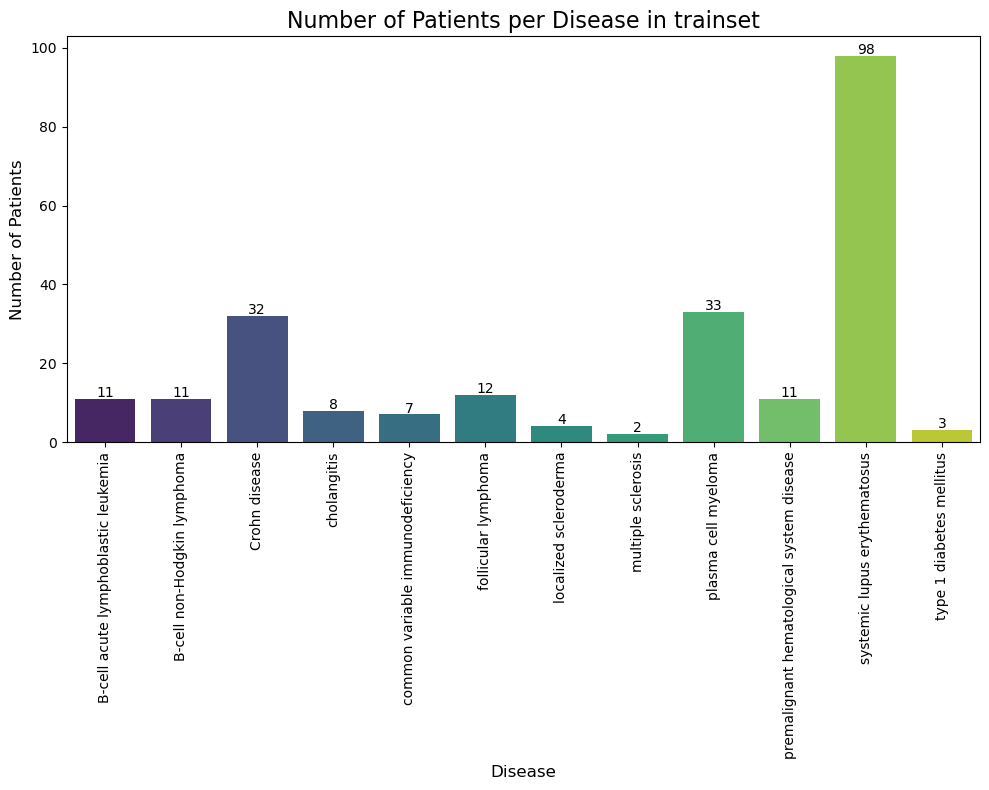

In [43]:
# Number of Patients per Disease in trainset
counts = (
    train_adata.obs[
        (train_adata.obs['is_real_cell'] == 'real') | (train_adata.obs['is_real_cell'] == 'augmented')
    ]
    .groupby('disease')['donor_id']
    .nunique()
)

# Create the barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=counts.index, y=counts.values, palette="viridis")

# Add labels above the bars
for i, value in enumerate(counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', fontsize=10)

# Add labels and title
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.title("Number of Patients per Disease in trainset", fontsize=16)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [44]:
#Count number of real cells in test set
val_adata.obs['disease'].value_counts()

disease
B-cell acute lymphoblastic leukemia          500
B-cell non-Hodgkin lymphoma                  500
Crohn disease                                500
cholangitis                                  500
common variable immunodeficiency             500
follicular lymphoma                          500
localized scleroderma                        500
multiple sclerosis                           500
plasma cell myeloma                          500
premalignant hematological system disease    500
systemic lupus erythematosus                 500
type 1 diabetes mellitus                     500
Name: count, dtype: int64

In [45]:
#Count number of cells in train set
train_adata.obs['disease'].value_counts()

disease
cholangitis                                  221146
Crohn disease                                146165
systemic lupus erythematosus                 125261
B-cell acute lymphoblastic leukemia          123188
premalignant hematological system disease    114732
follicular lymphoma                          111697
B-cell non-Hodgkin lymphoma                  105943
type 1 diabetes mellitus                     104509
plasma cell myeloma                          104163
localized scleroderma                        103582
common variable immunodeficiency             100402
multiple sclerosis                            98474
Name: count, dtype: int64

In [52]:
# Count how many real and augmented cells are per disease in train set
train_adata.obs[(adata.obs['is_real_cell']=='real') | (adata.obs['is_real_cell']=='augmented')].groupby('disease').size().sort_values(ascending=False)

disease
Crohn disease                                90462
cholangitis                                  61156
B-cell acute lymphoblastic leukemia          42909
systemic lupus erythematosus                 32136
common variable immunodeficiency             22539
follicular lymphoma                          21721
premalignant hematological system disease    18694
B-cell non-Hodgkin lymphoma                  17814
type 1 diabetes mellitus                      6921
plasma cell myeloma                           6692
multiple sclerosis                            3369
localized scleroderma                          457
dtype: int64

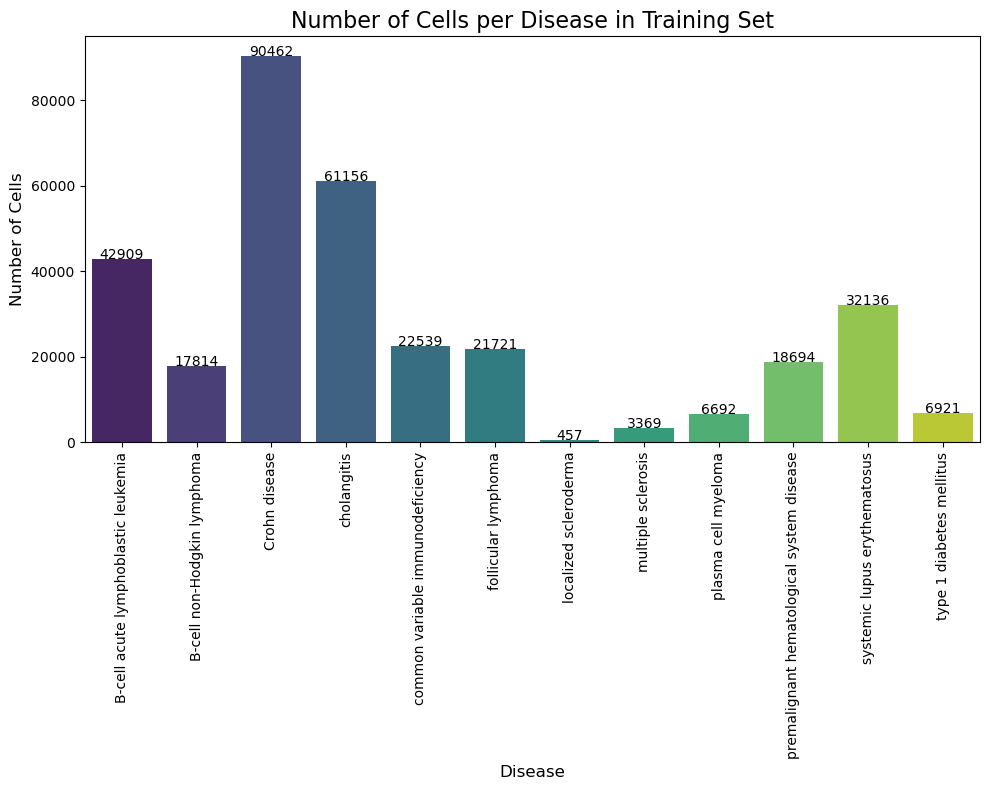

In [53]:
# Prepare the data
counts = (
    train_adata.obs[
        (train_adata.obs['is_real_cell'] == 'real') | (train_adata.obs['is_real_cell'] == 'augmented')
    ]
    .groupby('disease')
    .size()
)

# Create the barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=counts.index, y=counts.values, palette="viridis")

# Add labels above the bars
for i, value in enumerate(counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', fontsize=10)

# Add labels and title
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Number of Cells", fontsize=12)
plt.title("Number of Cells per Disease in Training Set", fontsize=16)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [54]:
#Create training and test set, downsample the data to float16 to save memory
X_train = train_adata.X.toarray().astype('float16')
X_test = val_adata.X.toarray().astype('float16')
y_train = train_adata.obs['disease']
y_test = val_adata.obs['disease']

## Note:
    To lower memory needs I have created smaller datasets containing 2% of original training set

In [55]:
#Create small set for training 
X_train95, X_train05, y_train95, y_train05 = train_test_split(X_train, y_train, test_size=0.02, random_state=42)

In [56]:
#Create training and test set for real and augmented cells only, downsample the data to float16 to save memory
is_real_train= np.where((train_adata.obs['is_real_cell']=='real') | (train_adata.obs['is_real_cell']=='augmented'), 1, 0)
X_train_real = X_train[is_real_train==1]
y_train_real = y_train[is_real_train==1]
X_train_real90, X_train_real10, y_train_real90, y_train_real10 = train_test_split(X_train_real, y_train_real, test_size=0.10, random_state=42)

# Analysis: Baseline model

## Dummy classifier fake cells

,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
Dummy classifier + fake cells,0.15,0.083,0.007,0.083,0.013,0.5,0.0


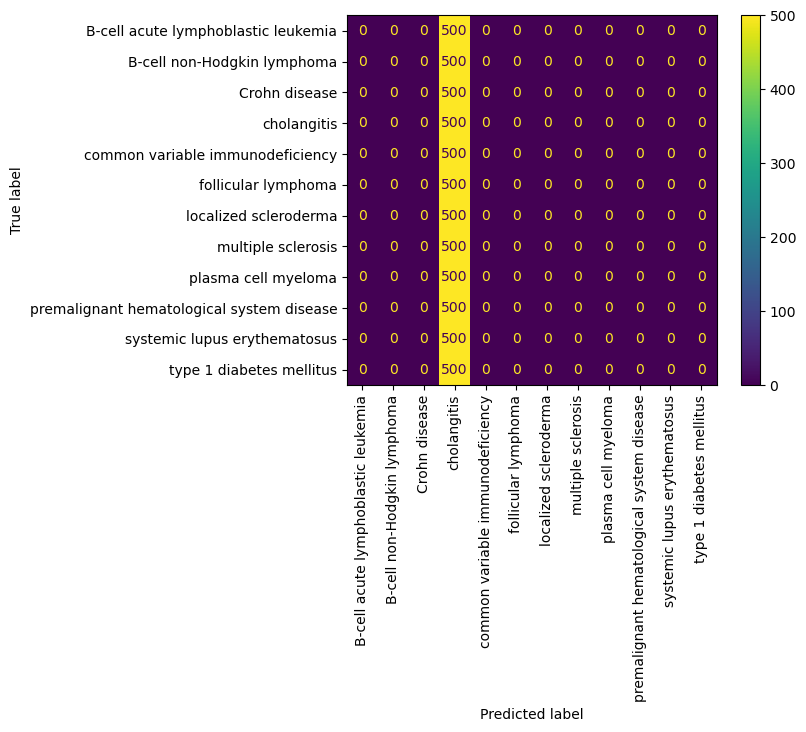

In [57]:
start_time = time.time()
pipe = DummyClassifier().fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = pipe.predict(X_test)
acc_train = pipe.score(X_train05,y_train05)
acc_test = pipe.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = pipe.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

#Save results in the dataframe 
dummy1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['Dummy classifier  + fake cells'])
dummy1_report_df = pd.DataFrame(report)
dummy1_df

# Models without cell type bias

## KNN Classifier without cell type bias

Best Parameters:  {'knn__n_neighbors': 17}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
KNN classifier + fake cells,0.279,0.314,0.398,0.314,0.301,0.66,87.2


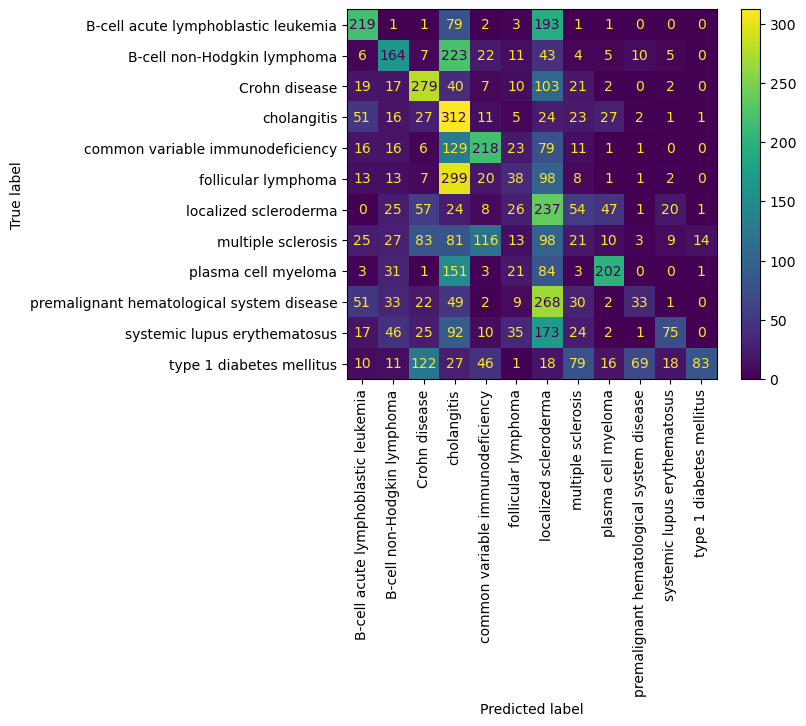

In [58]:
#Set up pipeline
pipe = Pipeline([('knn',KNeighborsClassifier(n_jobs=-1))])

# parameters to search
params_knn = {'knn__n_neighbors':[3,7,11,17,25],
#              'knn__p' :[1, 2]
#              'knn__weights' : ('uniform', 'distance'),
#              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#              'knn__leaf_size': [10, 20, 30, 40, 50],
#              'knn__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
#              'poly_features__degree': [1,2,3],
#              'poly_features__include_bias': [True, False]
}            


start_time = time.time()
grid = RandomizedSearchCV(pipe, param_distributions=params_knn, scoring='f1_weighted',refit='recall',n_jobs=3, pre_dispatch="2*n_jobs",n_iter=10, cv=3).fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
knn1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['KNN classifier + fake cells'])
knn1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
knn1_df

## Logistic Regression without cell type bias

Best Parameters:  {'logreg__C': 9.999999999999999e-05}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
LogReg classifier + fake cells,0.379,0.75,0.745,0.75,0.707,0.921,147.6


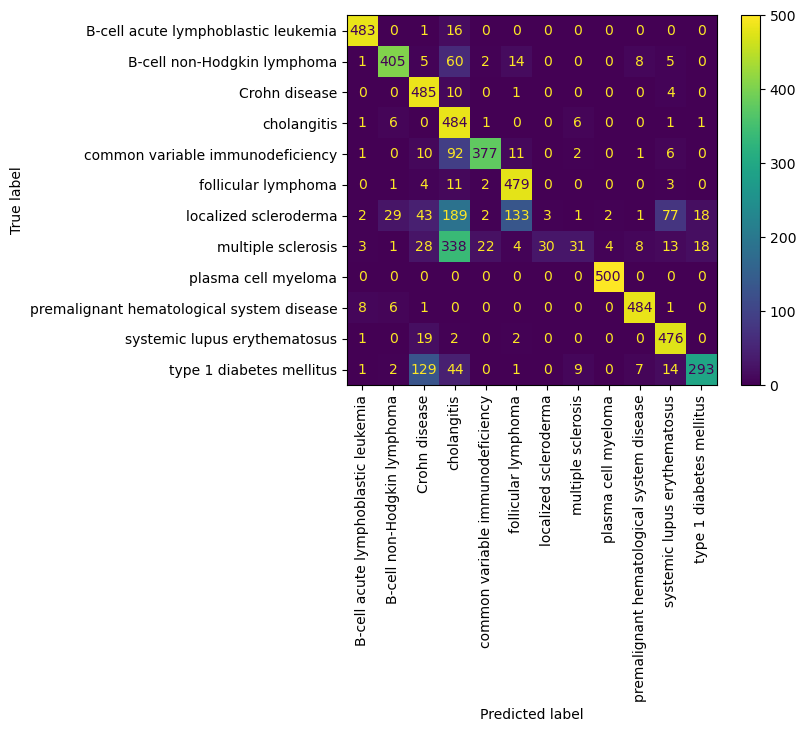

In [59]:
#Define the Logistic regression pipeline 
logreg_pipe = Pipeline([('scaler',StandardScaler()),('logreg',LogisticRegression(n_jobs=-1,max_iter=2000))])
# Define hyperparameters to search
param_logreg = {'logreg__C': np.logspace(-4, 4, 5),
#                'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#                'logreg__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cholesky'],  # 'newton-cg' and 'sag' only support l2
#                'logreg__class_weight': [None, 'balanced'],
#                'logreg__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
#                'logreg__tol': [1e-4, 1e-3, 1e-2, 1e-1],
#                'logreg__fit_intercept': [True, False],
}
start_time = time.time()
grid = RandomizedSearchCV(logreg_pipe, param_distributions=param_logreg, scoring='f1_weighted',n_jobs=3, refit='recall', pre_dispatch="2*n_jobs",n_iter=10, cv=3).fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
logreg1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['LogReg classifier + fake cells'])
logreg1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
logreg1_df

## Decision Tree Classifier without cell type bias

Best Parameters:  {'tree__max_depth': 48}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
DecisionTree classifier + fake cells,0.746,0.441,0.438,0.441,0.429,0.711,238.8


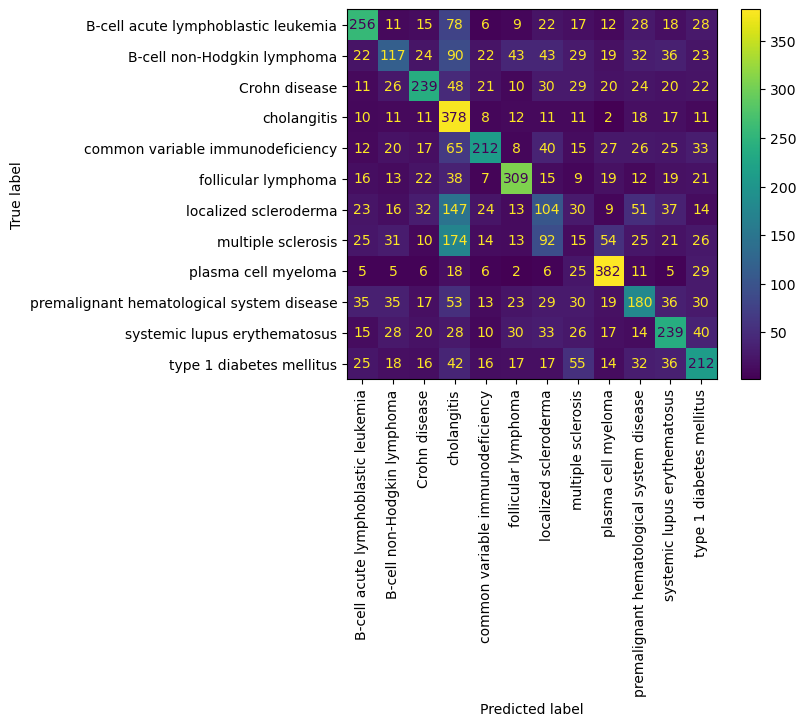

In [60]:
#Define the Decision tree pipeline of DecisionTreeClassifier
dtree_pipe = Pipeline([('tree', DecisionTreeClassifier())])

#Hyperparameters to search
params = {
    'tree__max_depth': [None,3,12,48,96],  # Try a range of depths or leave as None for no limit
#    'tree__min_samples_split': [0.0001, 0.001, 0.01, 0.1],  # Minimum number of samples required to split a node
#    'tree__criterion': ['gini', 'entropy'],  # Metrics to measure the quality of a split
#    'tree__min_samples_leaf': [1,2,4,8,16],  # Minimum number of samples required at a leaf node
}
#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(dtree_pipe, param_distributions=params,  scoring='f1_weighted',n_jobs=3, refit='recall', pre_dispatch="2*n_jobs",n_iter=10, cv=3).fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
dtree1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['DecisionTree classifier + fake cells'])
dtree1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
dtree1_df

## Linear SVC without cell type bias

/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/

Best Parameters:  {'svc__estimator__C': 0.1}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
Linear SVC + fake cells,0.376,0.411,0.556,0.411,0.365,0.837,4015.7


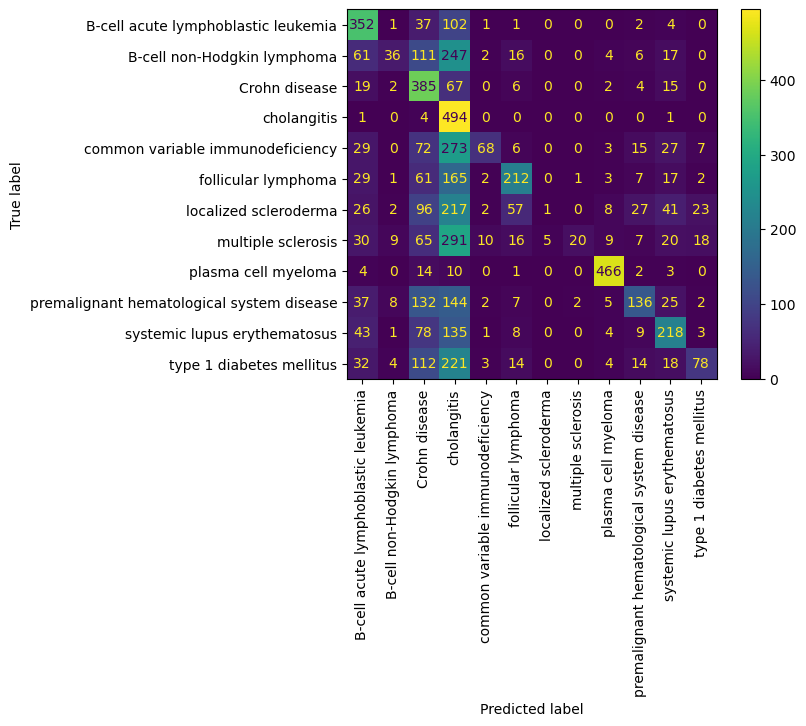

In [61]:
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore")

# Define the pipeline with LinearSVC and calibration
svc_pipe = Pipeline([
    ('svc', CalibratedClassifierCV(
        estimator=LinearSVC(max_iter=500, class_weight='balanced'),
        method='sigmoid'
    ))
])

# Hyperparameters to search
svc_params = {
    'svc__estimator__C': [0.1, 10]  # Regularization strength
}

#Perform RandomizedSearchCV on svc pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(svc_pipe, param_distributions=svc_params, scoring='f1_weighted',n_jobs=4, refit='recall', pre_dispatch="2*n_jobs",n_iter=2, cv=3).fit(X_train05,y_train05)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train05,y_train05)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
svc1_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['Linear SVC + fake cells'])
svc1_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
svc1_df

# Models with cell type bias

## Dummy classifier real cells

,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
Dummy classifier + real cells,0.281,0.083,0.007,0.083,0.013,0.5,0.0


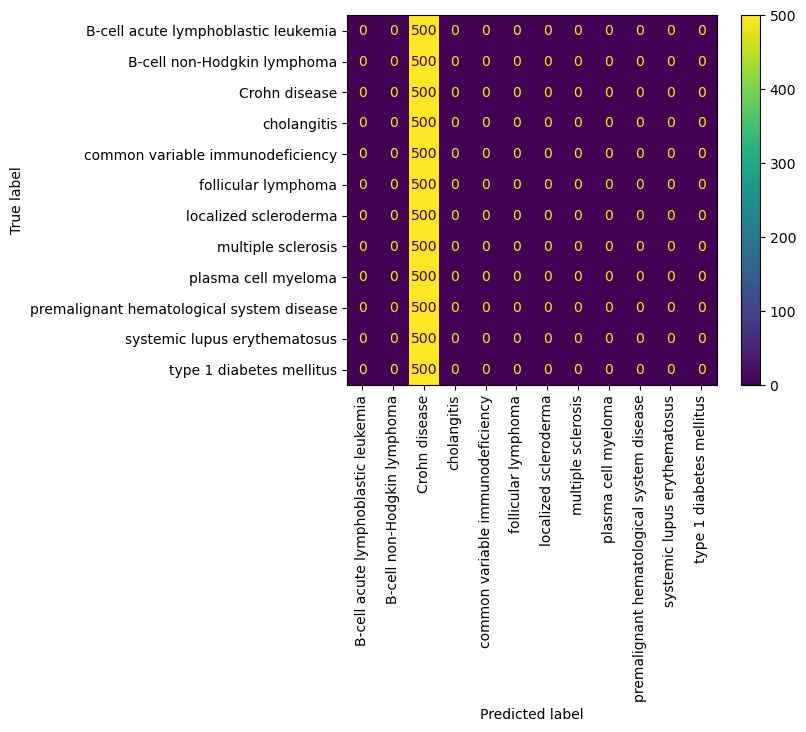

In [64]:
start_time = time.time()
pipe = DummyClassifier().fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = pipe.predict(X_test)
acc_train = pipe.score(X_train_real10,y_train_real10)
acc_test = pipe.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = pipe.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

#Save results in the dataframe 
dummy2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['Dummy classifier + real cells'])
dummy2_report_df = pd.DataFrame(report)
dummy2_df

## KNN - real cells only

Best Parameters:  {'knn__n_neighbors': 3}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
KNN classifier + real cells,0.735,0.544,0.815,0.544,0.544,0.802,144.6


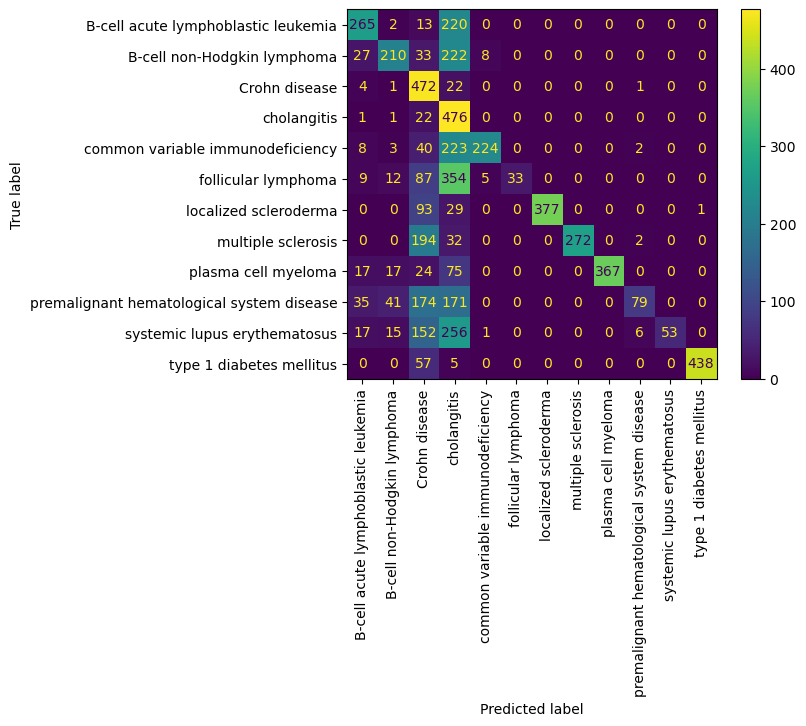

In [65]:
#Set up pipeline
pipe = Pipeline([('knn',KNeighborsClassifier(n_jobs=-1))])

# parameters to search
params_knn = {'knn__n_neighbors':[3,5,7,9,13,17,25],
#              'knn__p' :[1, 2]
#              'knn__weights' : ('uniform', 'distance'),
#              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#              'knn__leaf_size': [10, 20, 30, 40, 50],
#              'knn__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
#              'poly_features__degree': [1,2,3],
#              'poly_features__include_bias': [True, False]
}            


start_time = time.time()
grid = RandomizedSearchCV(pipe, param_distributions=params_knn, scoring='f1_weighted',refit='recall',n_jobs=3, pre_dispatch="2*n_jobs",n_iter=10, cv=3).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
knn2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['KNN classifier + real cells'])
knn2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
knn2_df

## Logistic regression - real cells only

Best Parameters:  {'logreg__C': 10.0}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
LogReg classifier + real cells,1.0,0.994,0.994,0.994,0.994,1.0,85.7


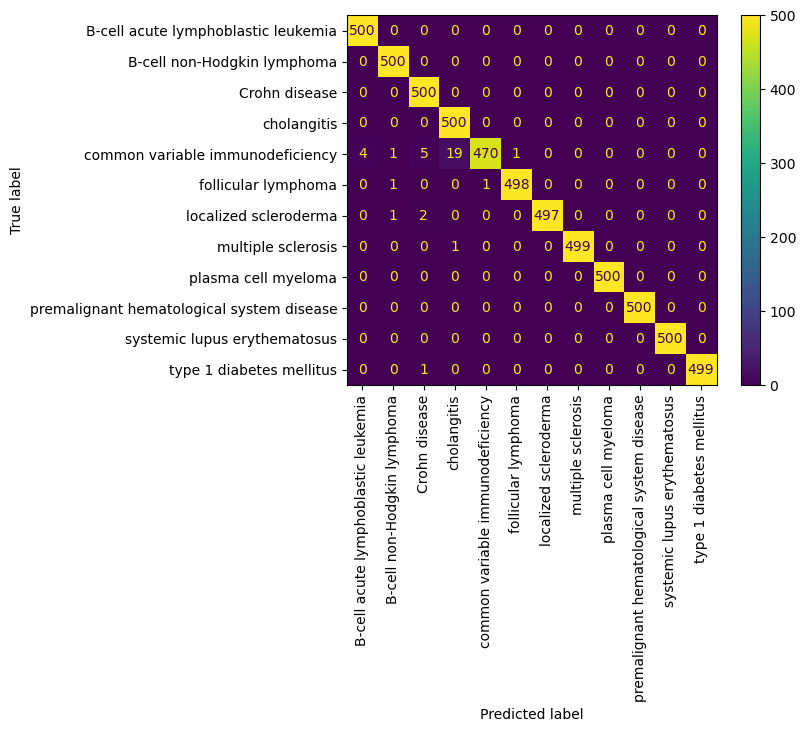

In [66]:
#Define the Logistic regression pipeline 
logreg_pipe = Pipeline([('scaler',StandardScaler()),('logreg',LogisticRegression(n_jobs=-1,max_iter=2000, class_weight='balanced'))])
# Define hyperparameters to search
param_logreg = {'logreg__C': np.logspace(-4, 4, 9),
#                'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#                'logreg__solver': ['lbfgs', 'liblinear', 'saga', 'newton-cholesky'],  # 'newton-cg' and 'sag' only support l2
#                'logreg__class_weight': [None, 'balanced'],
#                'logreg__l1_ratio': [0.0, 0.1, 0.25, 0.5, 0.75, 1.0],
#                'logreg__tol': [1e-4, 1e-3, 1e-2, 1e-1],
#                'logreg__fit_intercept': [True, False]
}
start_time = time.time()
grid = RandomizedSearchCV(logreg_pipe, param_distributions=param_logreg, scoring='f1_weighted',n_jobs=3, refit='recall', pre_dispatch="2*n_jobs",n_iter=10, cv=3).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
logreg2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['LogReg classifier + real cells'])
logreg2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
logreg2_df

## Decision Tree with real cells

Best Parameters:  {'tree__min_samples_split': 0.0001, 'tree__max_depth': 48}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
DecisionTree classifier + real cells,0.992,0.856,0.883,0.856,0.852,0.923,296.4


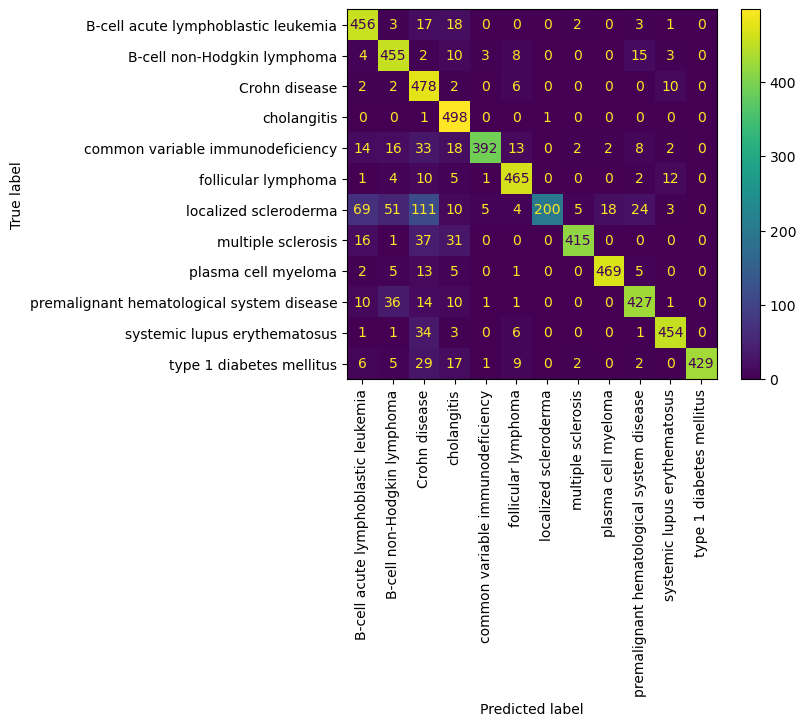

In [67]:
#Define the Decision tree pipeline of DecisionTreeClassifier
dtree_pipe = Pipeline([('tree', DecisionTreeClassifier())])

#Hyperparameters to search
params = {
    'tree__max_depth': [None,3,12,48,96],  # Try a range of depths or leave as None for no limit
    'tree__min_samples_split': [0.0001, 0.001, 0.01, 0.1],  # Minimum number of samples required to split a node
#    'tree__criterion': ['gini', 'entropy'],  # Metrics to measure the quality of a split
#    'tree__min_samples_leaf': [1,2,4,8,16],  # Minimum number of samples required at a leaf node
}
#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(dtree_pipe, param_distributions=params,  scoring='f1_weighted',n_jobs=3, refit='recall', pre_dispatch="2*n_jobs",n_iter=10, cv=3).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
dtree2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['DecisionTree classifier + real cells'])
dtree2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params)
dtree2_df

## Linear SVC with real cells

/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/envs/my-conda-env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adrian/.conda/

Best Parameters:  {'svc__estimator__C': 10}


,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
Linear SVC + Real cells,1.0,0.993,0.993,0.993,0.993,1.0,217.7


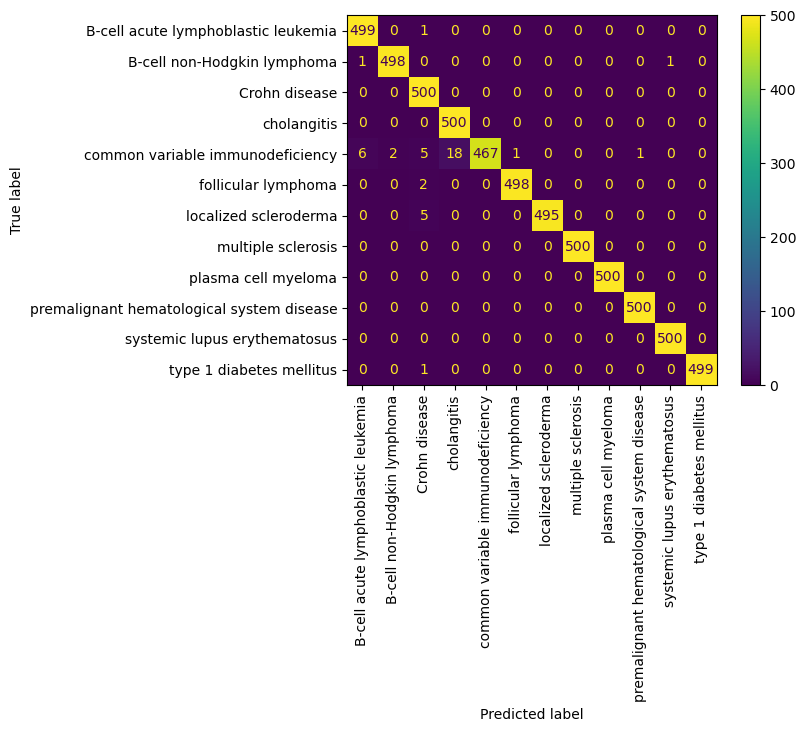

In [68]:
# Suppress ConvergenceWarning
warnings.filterwarnings("ignore")

# Define the pipeline with LinearSVC and calibration
svc_pipe = Pipeline([
    ('svc', CalibratedClassifierCV(
        estimator=LinearSVC(max_iter=2000, class_weight='balanced'),
        method='sigmoid'
    ))
])

# Hyperparameters to search
svc_params = {
    'svc__estimator__C': [0.1, 1, 10]  # Regularization strength
}
#Perform RandomizedSearchCV on svc pipe and fit data, measure time necessary for training
start_time = time.time()
grid = RandomizedSearchCV(svc_pipe, param_distributions=svc_params, scoring='f1_weighted',n_jobs=4, refit='recall', pre_dispatch="2*n_jobs",n_iter=3, cv=3).fit(X_train_real10,y_train_real10)
end_time = time.time()

#How much time did it take
execution_time = end_time - start_time  # Calculate the elapsed time

#Fidelity scores
preds = grid.best_estimator_.predict(X_test)
acc_train = grid.best_estimator_.score(X_train_real10,y_train_real10)
acc_test = grid.best_estimator_.score(X_test,y_test)
report = classification_report(y_test, preds, output_dict=True)

#Confusion matrix
labels = disease_one_hot_df.columns.to_list()
confusion_mat = confusion_matrix(y_test,preds,labels=labels)
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=labels).plot()
plt.xticks(rotation=90)

#Weighted avg ROC AUC
y_score = grid.best_estimator_.predict_proba(X_test)
roc_auc_value = roc_auc_score(y_test, y_score, average='weighted', multi_class='ovr')

# Get the best hyperparameters
best_params = grid.best_params_

#Save results in the dataframe 
svc2_df = pd.DataFrame({'Training accuracy':[round(acc_train,3)],
              'Test accuracy':[round(acc_test,3)],
              'Weighted avg precision':[round(report['weighted avg']['precision'],3)],
              'Weighted avg recall':[round(report['weighted avg']['recall'],3)],
              'Weighted avg F-1 score':[round(report['weighted avg']['f1-score'],3)],
              'Weighted ROC AUC':[round(roc_auc_value,3)],
              'Training time[s]':[round(execution_time,1)]
             },index=['Linear SVC + Real cells'])
svc2_report_df = pd.DataFrame(report)
print('Best Parameters: ', best_params) 
svc2_df

# Summary:

In [69]:
summary1 = pd.concat([dummy1_df,logreg1_df,svc1_df,dtree1_df,knn1_df,dummy2_df,logreg2_df,svc2_df,dtree2_df,knn2_df])
summary1

,Training accuracy,Test accuracy,Weighted avg precision,Weighted avg recall,Weighted avg F-1 score,Weighted ROC AUC,Training time[s]
Dummy classifier + fake cells,0.150,0.083,0.007,0.083,0.013,0.500,0.0
LogReg classifier + fake cells,0.379,0.750,0.745,0.750,0.707,0.921,147.6
Linear SVC + fake cells,0.376,0.411,0.556,0.411,0.365,0.837,4015.7
DecisionTree classifier + fake cells,0.746,0.441,0.438,0.441,0.429,0.711,238.8
KNN classifier + fake cells,0.279,0.314,0.398,0.314,0.301,0.660,87.2
Dummy classifier + real cells,0.281,0.083,0.007,0.083,0.013,0.500,0.0
LogReg classifier + real cells,1.000,0.994,0.994,0.994,0.994,1.000,85.7
Linear SVC + Real cells,1.000,0.993,0.993,0.993,0.993,1.000,217.7
DecisionTree classifier + real cells,0.992,0.856,0.883,0.856,0.852,0.923,296.4
KNN classifier + real cells,0.735,0.544,0.815,0.544,0.544,0.802,144.6


# Conclusions:  
1. Logistic regression achieved the best results from the perspective of recall, precision, and consequently F-1 score.
2. Logisitc regression scales better than LinearSVC with the size of dataset.
3. The best model (Logistic Regression) for dataset without cell type bias struggle with localized sleroderma and type 1 diabetes. These diseases also have the fewest donors, it is anticipated that accuracy of the prediction would increase with more patients in training. 

# Next steps:
1. Very few cells have been used in training due to resource limits, a more deeper training would yield better results.
2. Current model performs inferences per cell, wheras multiple cells are available per patient, a model that could take multiple per cell predictions and use them for majority voting would give better results.
3. Current model does not predict whether patient is healthy, it would be critical to include healthy donors for each disease.